<AxesSubplot:xlabel='Year'>

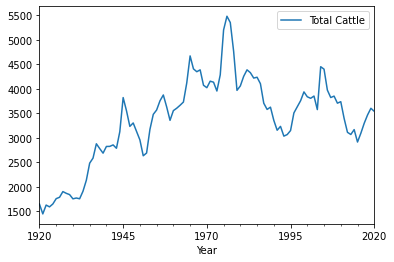

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel('Canada Cattle.xlsx')

# Set Year as index and convert to_period to yearly
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')
df = df.to_period('Y')

# df.describe()

# Copy the dataframe
df_full = df

# Drop the columns we don't need
df['Total Cattle'] = df['Count of Cattle'] + df['Count of Calves']
df.drop(['Count of Cattle', 'Count of Calves', 'Average Weight Cattle', 'Average Weight Calves'], axis=1, inplace=True)

# Multiply Total Cattle by 1000
# df['Total Cattle'] = df['Total Cattle'] * 1000

# df.head()
df.plot()

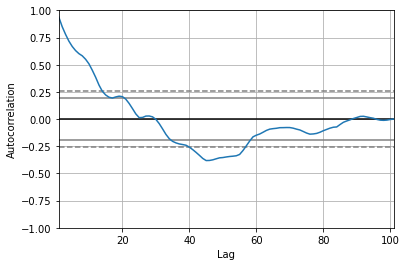

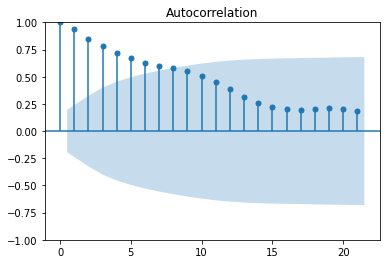

In [2]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

autocorrelation_plot(df)
plot_acf(df)
plt.show()

In [3]:
# Use Dickey-Fuller test to test for stationarity
from statsmodels.tsa.stattools import adfuller

# Test for stationarity
result = adfuller(df['Total Cattle'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.226923
p-value: 0.196620
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


In [4]:
# Convert a differenced series to a stationary series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# Invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

# Create a differenced series
diff = difference(df['Total Cattle'])

# Invert the differenced series
inverted = [inverse_difference(df.values[i], diff[i]) for i in range(len(diff))]

In [5]:
# Check for stationarity on the differenced series
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -7.589221
p-value: 2.557774350419046e-11
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


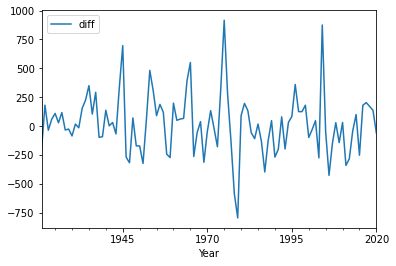

In [6]:
# Convert differenced series to a time-series data, first column is year with index, second column is the difference
df_diff = pd.DataFrame(diff)

# Rename Index to year
df_diff.index.name = 'Year'

# Add 1921 to the index
df_diff.index = df_diff.index + 1921

# Rename Column to difference
df_diff.columns = ['diff']

# Change index to datetime year
df_diff.index = pd.to_datetime(df_diff.index, format='%Y')
# Set index to period year
df_diff = df_diff.to_period('Y')

# Plot the differenced series
df_diff.plot()

# Rename dataframes
df_old = df
# df = df_diff


                               SARIMAX Results                                
Dep. Variable:           Total Cattle   No. Observations:                  101
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -705.702
Date:                Mon, 27 Jun 2022   AIC                           1417.404
Time:                        15:34:33   BIC                           1425.250
Sample:                    12-31-1920   HQIC                          1420.580
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3367.2762    460.105      7.319      0.000    2465.488    4269.065
ar.L1          0.9632      0.024     40.378      0.000       0.916       1.010
sigma2       6.69e+04   6448.909     10.373      0.0

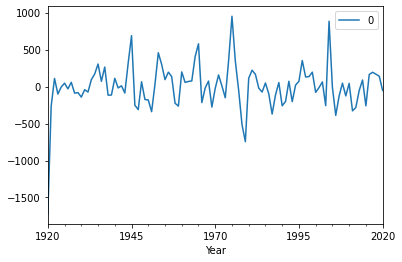

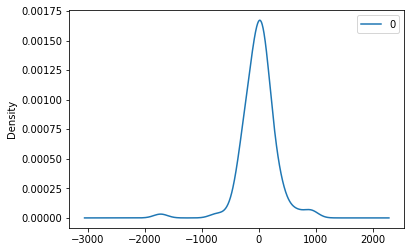

             0
count   101.00
mean      1.65
std     308.28
min   -1721.98
25%    -126.27
50%      10.17
75%     133.41
max     950.52


In [8]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary of residuals
print(residuals.describe())


predicted=3995.369803, expected=3836.100000
predicted=3803.538184, expected=3804.600000
predicted=3794.257715, expected=3850.600000
predicted=3865.692136, expected=3574.200000
predicted=3484.218759, expected=4449.700000
predicted=4690.685919, expected=4399.800000
predicted=4388.109427, expected=3971.900000
predicted=3870.272359, expected=3820.400000
predicted=3783.901992, expected=3849.200000
predicted=3856.095885, expected=3705.200000
predicted=3670.811048, expected=3735.700000
predicted=3742.941558, expected=3393.900000
predicted=3313.331028, expected=3110.300000
predicted=3040.442190, expected=3066.100000
predicted=3055.257914, expected=3165.500000
predicted=3189.814844, expected=2912.000000
predicted=2851.045025, expected=3091.700000
predicted=3133.278248, expected=3294.800000
predicted=3342.673779, expected=3464.700000
predicted=3505.376298, expected=3600.600000
predicted=3633.465730, expected=3539.100000


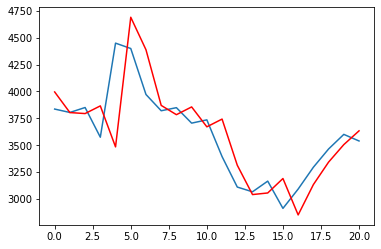

Test RMSE: 285.119
Test MAPE: 0.054
Test MAD: 199.585


In [9]:
# evaluate an ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Split dataset into train and test
x = df.values
size = int(len(df) * 0.8)
train, test = x[0:size], x[size:len(df)]
history = [x for x in train]
predictions = []

# Walk-forward validation for ARIMA model
for i in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
error = mean_squared_error(test, predictions)

# plot forecasts against actual values
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Calculate RMSE
rmse = sqrt(error)
print('Test RMSE: %.3f' % rmse)

# Calculate MAPE
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.3f' % mape)

# Calculate MAD
mad = mean_absolute_error(test, predictions)
print('Test MAD: %.3f' % mad)



In [13]:
# Create an LSTM model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

df = df_diff

# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Define input sequence
raw_seq = df.values
# Choose a number of time steps
n_steps = 3
# Split into samples
x, y = split_sequence(raw_seq, n_steps)
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
x = x.reshape((x.shape[0], x.shape[1], n_features))
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Fit model
model.fit(x, y, epochs=200, verbose=0)
# Make predictions
predictions = model.predict(x)
# demonstrate prediction
x_input = array([[raw_seq[-3], raw_seq[-2], raw_seq[-1]]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y, predictions))
print('Test RMSE: %.3f' % rmse)

df = df_old

4/4 [==============================] - 0s 1ms/step
[[-112.83625]]
Test RMSE: 135.514


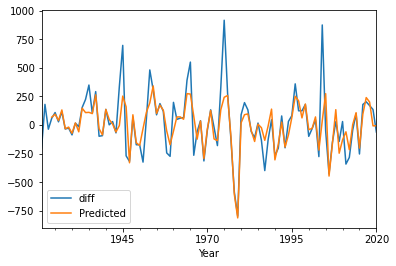

In [155]:
# Compare actual and predicted values in pvt_yr dataframe

pred = [None, None, None]
pred.extend(predictions.flatten())

prt_yr = df_diff.copy()
prt_yr['Predicted'] = pred

# Plot actual and predicted values
prt_yr.plot()
plt.show()